In [1]:
import pandas as pd
import numpy as np
import os
import random
from copy import deepcopy
import math
from itertools import product
import pickle
import joblib
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# 전후 값 기반 null 대체

## 준비

In [6]:
merged_df = pd.read_csv('./customData/merged_user_loan.csv', index_col=0)

In [3]:
merged_df.columns

Index(['application_id', 'user_id', 'birth_year', 'gender', 'insert_time',
       'credit_score', 'yearly_income', 'income_type', 'company_enter_month',
       'employment_type', 'houseown_type', 'desired_amount', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt', 'loanapply_insert_time',
       'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'is_applied'],
      dtype='object')

초기 null 상태

In [11]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                               128096
gender                                   128096
credit_score                            1509276
yearly_income                                 6
company_enter_month                      400337
personal_rehabilitation_yn              5888701
personal_rehabilitation_complete_yn    11793977
existing_loan_cnt                       2685709
existing_loan_amt                       3890163
loan_limit                                 7382
loan_rate                                  7382
is_applied                              3257239
dtype: int64

In [4]:
merged_df=merged_df.sort_values(by=['user_id', 'loanapply_insert_time'])

In [5]:
user_id_list = list(merged_df['user_id'])

In [6]:
idx_uid_list=[]
for uid in tqdm(set(user_id_list)):
    idx_uid_list.append((user_id_list.index(uid),uid))

100%|█████████████████████████████████████████████████████████████████████████| 317467/317467 [3:21:11<00:00, 26.30it/s]


In [7]:
idx_uid_list.sort()

In [8]:
# idx_uid_list

In [9]:
merged_df.reset_index(inplace=True)

실습

In [28]:
a=pd.DataFrame([
    list(range(1,10)),
    list(range(8,17)),
    [0]*9,
    list(range(31, 13, -2))
])

In [37]:
a.iloc[:,0]=np.NaN

In [35]:
a.iloc[0,0] = 1
a.iloc[0,3] = 2

In [46]:
a.fillna(method='bfill')

,0,1,2,3,4,5,6,7,8
0,NaN,9.0,10.0,2.0,12.0,13.0,14.0,15.0,16.0
1,NaN,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,29.0,27.0,25.0,23.0,21.0,19.0,17.0,15.0


In [42]:
a.fillna(method='ffill').isnull().sum()

0    4
1    1
2    1
3    0
4    1
5    1
6    1
7    1
8    1
dtype: int64

## 앞뒤값으로 null 채우기

In [10]:
len(idx_uid_list) # 61148

317467

In [12]:
result = pd.DataFrame()
for i, v in tqdm(enumerate(idx_uid_list[:-1])):
    idx=v[0]
    result= pd.concat([result, merged_df.iloc[idx:idx_uid_list[i+1][0]].fillna(method='ffill').fillna(method='bfill')])

163665it [13:14:27,  3.43it/s]


KeyboardInterrupt: 

In [13]:
result.to_csv('./customData/imcompleted_merged_ver0_5.csv')

In [19]:
pd.DataFrame(idx_uid_list).to_csv('./customData/idx.csv')

In [18]:
merged_df.to_csv('./customData/work_target.csv')

## 분할 작업 합치기

In [3]:
final=pd.concat([pd.read_csv('./customData/imcompleted_merged_ver0_5.csv'), pd.read_csv('./customData/result1.csv'), 
                 pd.read_csv('./customData/result2.csv'), pd.read_csv('./customData/result3.csv'), 
                 pd.read_csv('./customData/result4.csv')])

In [4]:
(final.isnull().sum())[final.isnull().sum()!=0]

birth_year                               108227
gender                                   108227
credit_score                            1311773
company_enter_month                      306537
personal_rehabilitation_yn              2934375
personal_rehabilitation_complete_yn    11162940
existing_loan_cnt                       2685709
existing_loan_amt                       3890163
loan_limit                                   10
loan_rate                                    10
is_applied                              1454013
dtype: int64

In [7]:
final['is_applied']=merged_df['is_applied']

In [14]:
final.drop(['Unnamed: 0'], axis=1,inplace=True)

In [8]:
final.to_csv('./customData/merged_ver0_5.csv')

In [15]:
final['index'] = final.index

In [16]:
final.to_csv('./customData/merged_ver1_0.csv')

# 의미를 부여하여 결측치 처리하기

## 데이터 확인

In [9]:
(final.isnull().sum())[final.isnull().sum()!=0]

birth_year                               108227
gender                                   108227
credit_score                            1311773
company_enter_month                      306537
personal_rehabilitation_yn              2934375
personal_rehabilitation_complete_yn    11162940
existing_loan_cnt                       2685709
existing_loan_amt                       3890163
loan_limit                                   10
loan_rate                                    10
is_applied                              3322044
dtype: int64

In [10]:
(final[final['is_applied'].isnull()==True].isnull().sum())[final[final['is_applied'].isnull()==True].isnull().sum()!=0]

birth_year                               25987
gender                                   25987
credit_score                            321957
company_enter_month                      77123
personal_rehabilitation_yn              718426
personal_rehabilitation_complete_yn    2719745
existing_loan_cnt                       661561
existing_loan_amt                       956118
loan_limit                                   1
loan_rate                                    1
is_applied                             3322044
dtype: int64

In [11]:
loan_df=pd.read_csv('./data/loan_result.csv')

In [12]:
(loan_df[loan_df['is_applied'].isnull()==True].isnull().sum())[loan_df[loan_df['is_applied'].isnull()==True].isnull().sum()!=0]

loan_limit       1757
loan_rate        1757
is_applied    3257239
dtype: int64

## existing_loan_cnt & existing_loan_amt

In [17]:
merged_df =pd.read_csv('./customData/merged_ver1_0.csv', index_col=0)

In [ ]:
merged_df.reset_index(inplace=True)

In [28]:
merged_df.drop(['index','level_0'],axis=1, inplace=True)

In [2]:
merged_df.to_csv('./customData/merged_ver1_0.csv')

NameError: name 'merged_df' is not defined

In [3]:
merged_df =pd.read_csv('./customData/merged_ver1_0.csv', index_col=0)

In [4]:
merged_df

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,...,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied
0,248576,9,1996.0,1.0,2022-05-21 23:41:09,810.0,29000000.0,EARNEDINCOME,202201.0,계약직,...,0.0,NaN,1.0,NaN,2022-05-21 23:41:09,38,134,16000000.0,7.5,NaN
1,248576,9,1996.0,1.0,2022-05-21 23:41:09,810.0,29000000.0,EARNEDINCOME,202201.0,계약직,...,0.0,NaN,1.0,NaN,2022-05-21 23:41:09,59,150,20000000.0,15.0,NaN
2,248576,9,1996.0,1.0,2022-05-21 23:41:09,810.0,29000000.0,EARNEDINCOME,202201.0,계약직,...,0.0,NaN,1.0,NaN,2022-05-21 23:41:09,59,251,16000000.0,6.5,NaN
3,248576,9,1996.0,1.0,2022-05-21 23:41:09,810.0,29000000.0,EARNEDINCOME,202201.0,계약직,...,0.0,NaN,1.0,NaN,2022-05-21 23:41:09,27,148,16000000.0,7.0,NaN
4,248576,9,1996.0,1.0,2022-05-21 23:41:09,810.0,29000000.0,EARNEDINCOME,202201.0,계약직,...,0.0,NaN,1.0,NaN,2022-05-21 23:41:10,35,168,28000000.0,16.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13527245,1543548,879697,1962.0,1.0,2022-05-10 20:40:52,NaN,70000000.0,EARNEDINCOME,202204.0,계약직,...,0.0,NaN,NaN,NaN,2022-05-10 20:40:55,64,254,28000000.0,6.9,0.0
13527246,1543548,879697,1962.0,1.0,2022-05-10 20:40:52,NaN,70000000.0,EARNEDINCOME,202204.0,계약직,...,0.0,NaN,NaN,NaN,2022-05-10 20:40:55,12,35,23000000.0,9.2,0.0
13527247,1543548,879697,1962.0,1.0,2022-05-10 20:40:52,NaN,70000000.0,EARNEDINCOME,202204.0,계약직,...,0.0,NaN,NaN,NaN,2022-05-10 20:41:07,52,187,3000000.0,5.4,0.0
13527248,1543548,879697,1962.0,1.0,2022-05-10 20:40:52,NaN,70000000.0,EARNEDINCOME,202204.0,계약직,...,0.0,NaN,NaN,NaN,2022-05-10 20:41:10,55,186,50000000.0,10.6,0.0


In [11]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                               108227
gender                                   108227
credit_score                            1311773
company_enter_month                      306537
personal_rehabilitation_yn              2934375
personal_rehabilitation_complete_yn    11162940
existing_loan_cnt                       2685709
existing_loan_amt                       3890163
loan_limit                                   10
loan_rate                                    10
is_applied                              3322044
dtype: int64

In [5]:
merged_df[(merged_df['existing_loan_amt'].isnull()==True)]['existing_loan_cnt'].value_counts()

1.0    1204454
Name: existing_loan_cnt, dtype: int64

In [5]:
merged_df.loc[merged_df[(merged_df['existing_loan_amt'].isnull()==True) & (merged_df['existing_loan_cnt']==1)].index, 'existing_loan_amt'] = -100

In [6]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                               108227
gender                                   108227
credit_score                            1311773
company_enter_month                      306537
personal_rehabilitation_yn              2934375
personal_rehabilitation_complete_yn    11162940
existing_loan_cnt                       2685709
existing_loan_amt                       2685709
loan_limit                                   10
loan_rate                                    10
is_applied                              3322044
dtype: int64

In [7]:
set(merged_df[merged_df['existing_loan_amt'].isnull()==True].index) ==\
set(merged_df[merged_df['existing_loan_cnt'].isnull()==True].index)

True

In [8]:
merged_df.loc[merged_df[merged_df['existing_loan_amt'].isnull()==True].index, ['existing_loan_amt', 'existing_loan_cnt']]=0

In [9]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                               108227
gender                                   108227
credit_score                            1311773
company_enter_month                      306537
personal_rehabilitation_yn              2934375
personal_rehabilitation_complete_yn    11162940
loan_limit                                   10
loan_rate                                    10
is_applied                              3322044
dtype: int64

## personal_rehabilitation_yn & personal_rehabilitation_complete_yn

In [11]:
merged_df[(merged_df['personal_rehabilitation_complete_yn'].isnull()==True)]['personal_rehabilitation_yn'].value_counts()

0.0    8228565
Name: personal_rehabilitation_yn, dtype: int64

In [12]:
merged_df.loc[merged_df[(merged_df['personal_rehabilitation_yn']==0)].index, 'personal_rehabilitation_complete_yn'] = -1

In [13]:
set(merged_df[merged_df['personal_rehabilitation_yn'].isnull()==True].index)\
== set(merged_df[merged_df['personal_rehabilitation_complete_yn'].isnull()==True].index)

True

In [14]:
merged_df.loc[merged_df[merged_df['personal_rehabilitation_yn'].isnull()==True].index, 'personal_rehabilitation_yn']=0

In [55]:
merged_df.loc[merged_df[merged_df['personal_rehabilitation_complete_yn'].isnull()==True].index, 'personal_rehabilitation_complete_yn']=-1

In [16]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0] # personal_rehabilitation_complete_yn  잘못표기됨

birth_year                              108227
gender                                  108227
credit_score                           1311773
company_enter_month                     306537
personal_rehabilitation_complete_yn    2934375
loan_limit                                  10
loan_rate                                   10
is_applied                             3322044
dtype: int64

## company_enter_month     

In [17]:
merged_df['company_enter_month']

0           202201.0
1           202201.0
2           202201.0
3           202201.0
4           202201.0
              ...   
13527245    202204.0
13527246    202204.0
13527247    202204.0
13527248    202204.0
13527249    202204.0
Name: company_enter_month, Length: 13527250, dtype: float64

In [18]:
merged_df['income_type'].unique()

array(['EARNEDINCOME', 'OTHERINCOME', 'EARNEDINCOME2', 'FREELANCER',
       'PRIVATEBUSINESS', 'PRACTITIONER'], dtype=object)

In [19]:
for income_type in merged_df['income_type'].unique():
    print(income_type, merged_df[merged_df['income_type']==income_type]['company_enter_month'].isnull().sum())

EARNEDINCOME 55
OTHERINCOME 306459
EARNEDINCOME2 0
FREELANCER 0
PRIVATEBUSINESS 23
PRACTITIONER 0


In [22]:
for income_type in merged_df[merged_df['is_applied'].isnull()==True]['income_type'].unique():
    print(income_type, merged_df[(merged_df['is_applied'].isnull()==True) & (merged_df['income_type']==income_type)]\
          ['company_enter_month'].isnull().sum())

EARNEDINCOME 4
OTHERINCOME 77119
EARNEDINCOME2 0
FREELANCER 0
PRIVATEBUSINESS 0
PRACTITIONER 0


In [30]:
merged_df[merged_df['income_type']=='OTHERINCOME']['company_enter_month'].value_counts()

202201.0      6119
202203.0      6017
202204.0      5121
202205.0      4153
202202.0      3403
              ... 
20210620.0       1
20180611.0       1
20180623.0       1
20120328.0       1
201010.0         1
Name: company_enter_month, Length: 833, dtype: int64

In [40]:
merged_df.loc[merged_df[merged_df['company_enter_month']<1_00_00_00].index, 'company_enter_month']= merged_df[merged_df['company_enter_month']<1_00_00_00]['company_enter_month'].copy()*100+1

In [37]:
merged_df.columnsumns

Index(['application_id', 'user_id', 'birth_year', 'gender', 'insert_time',
       'credit_score', 'yearly_income', 'income_type', 'company_enter_month',
       'employment_type', 'houseown_type', 'desired_amount', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt', 'loanapply_insert_time',
       'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'is_applied'],
      dtype='object')

In [47]:
merged_df['loanapply_insert_day']=pd.to_datetime(merged_df['loanapply_insert_time'])

In [43]:
merged_df['company_enter_month']=pd.to_datetime(merged_df['company_enter_month'], format='%Y%m%d')

In [52]:
merged_df['work_days']=(merged_df['loanapply_insert_day']-merged_df['company_enter_month']).dt.days

In [53]:
merged_df.drop(['loanapply_insert_day'],inplace=True,axis=1)

In [57]:
merged_df.drop(['company_enter_month'],inplace=True,axis=1)

In [59]:
merged_df.loc[merged_df[merged_df['work_days'].isnull()==True].index, 'work_days']=0

In [60]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year       108227
gender           108227
credit_score    1311773
loan_limit           10
loan_rate            10
is_applied      3322044
dtype: int64

In [61]:
loan_df = pd.read_csv('./data/loan_result.csv')

In [64]:
loan_df.shape, merged_df.shape

((13527363, 7), (13527250, 23))

In [67]:
len(loan_df[loan_df['is_applied'].isnull()==True])

3257239

In [70]:
tmp = pd.read_csv('./customData/merged_ver0_5.csv')

In [71]:
len(tmp[tmp['is_applied'].isnull()==True])

3322044

In [68]:
tmp.shape

(6968274, 25)

In [ ]:
merged_df.shape()

In [103]:
tmp['is_applied'].isnull().sum()

3257239

In [104]:
merged_df.shape

(2586455, 24)

## loan_limit & loan_rate

In [ ]:
merged_df=pd.read_csv('./customData/merged_ver1_0.csv',index_col=0)

In [ ]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

In [40]:
merged_df.drop(merged_df[merged_df['loan_limit'].isnull()==True].index, inplace=True)

In [41]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                              20771
gender                                  20771
credit_score                           249504
company_enter_month                     58008
personal_rehabilitation_yn             562201
personal_rehabilitation_complete_yn    562201
existing_loan_cnt                      514053
existing_loan_amt                      744017
is_applied                             619682
dtype: int64

In [99]:
merged_df[merged_df['is_applied'].isnull()==True]['insert_time'].str[:7].unique()

array(['2022-06', '2022-05'], dtype=object)

In [84]:
merged_df[['income_type','company_enter_month']]

,income_type,company_enter_month
0,EARNEDINCOME,202201.0
1,EARNEDINCOME,202201.0
2,EARNEDINCOME,202201.0
3,EARNEDINCOME,202201.0
4,EARNEDINCOME,202201.0
...,...,...
2586454,PRACTITIONER,201803.0
2586455,PRACTITIONER,201803.0
2586456,PRACTITIONER,201803.0
2586457,PRACTITIONER,201803.0


In [79]:
df = merged_df[merged_df['company_enter_month'].isnull()==True]

In [80]:
df.describe()

,index,application_id,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,bank_id,product_id,loan_limit,loan_rate,is_applied
count,5.800800e+04,5.800800e+04,58008.000000,56798.000000,56798.000000,49190.000000,5.800800e+04,0.0,5.800800e+04,58008.000000,58008.000000,58008.000000,5.800800e+04,58008.000000,58008.000000,5.800800e+04,58008.000000,43739.000000
mean,1.271071e+06,1.089368e+06,83087.060233,1978.565812,0.465192,753.692417,3.021876e+07,NaN,3.656842e+07,0.006206,0.000793,2.618104,3.150799e+07,27.789701,133.035685,1.574021e+07,14.355304,0.152244
std,7.507544e+05,6.230613e+05,49054.084103,12.111764,0.498791,118.077797,1.426775e+08,NaN,2.130780e+08,0.078534,0.028149,3.365334,6.137719e+07,17.243293,85.697828,1.560359e+07,3.577931,0.359261
min,1.620000e+02,1.240000e+02,19.000000,1933.000000,0.000000,300.000000,0.000000e+00,NaN,0.000000e+00,0.000000,0.000000,0.000000,-1.000000e+02,1.000000,1.000000,0.000000e+00,3.000000,0.000000
25%,5.999858e+05,5.488585e+05,39372.000000,1970.000000,0.000000,660.000000,1.000000e+07,NaN,5.000000e+06,0.000000,0.000000,0.000000,0.000000e+00,13.000000,56.000000,5.000000e+06,11.900000,0.000000
50%,1.234714e+06,1.097743e+06,80197.000000,1980.000000,0.000000,740.000000,2.300000e+07,NaN,1.300000e+07,0.000000,0.000000,2.000000,1.100000e+07,29.000000,123.000000,1.000000e+07,14.800000,0.000000
75%,1.918823e+06,1.625669e+06,125733.000000,1988.000000,1.000000,850.000000,3.500000e+07,NaN,3.000000e+07,0.000000,0.000000,4.000000,3.400000e+07,38.000000,205.000000,2.400000e+07,16.900000,0.000000
max,2.586231e+06,2.167709e+06,169182.000000,2002.000000,1.000000,1000.000000,8.000000e+09,NaN,1.000000e+10,1.000000,1.000000,76.000000,1.109000e+09,64.000000,270.000000,2.000000e+08,20.000000,1.000000


In [81]:
2022-1978

44

In [45]:
df = merged_df[merged_df['existing_loan_amt'].isnull()==True]

In [46]:
df['existing_loan_cnt'].unique()

array([ 1., nan])

In [50]:
len(df['user_id'].unique())

21372

In [51]:
x_test = merged_df[merged_df['is_applied'].isnull()==True]

In [55]:
df2 = x_test[x_test['existing_loan_amt'].isnull()==True]

In [56]:
df2['existing_loan_cnt'].unique()

array([nan,  1.])

In [57]:
len(df2['user_id'].unique())

6137

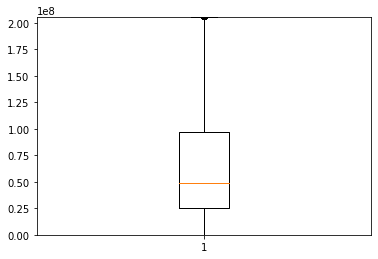

In [32]:
box=plt.boxplot(merged_df[merged_df['existing_loan_amt'].isnull()==False]['existing_loan_amt'], )
plt.ylim(0,2.05e+08)
plt.show()

In [30]:
box['whiskers'][1].get_ydata()

array([9.70e+07, 2.05e+08])

In [44]:
9.70e+07, 2.05e+08

(97000000.0, 205000000.0)

In [27]:
box['medians'][0].get_ydata()

array([49000000., 49000000.])

In [ ]:
old_id = user_id_list[0]
cnt=0
for uid in user_id_list:
    if uid != old_id:
        